In [1]:
import os
import pandas as pd
import torchvision
from torch.utils.data import Dataset, DataLoader
import torch
import random
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models.segmentation as models
import torch.optim as optim
import torchvision.utils as vutils
from tqdm import tqdm
import wandb
from torchvision.models import resnet50
import csv
from PIL import Image
import numpy as np
import ast  # Import the ast module to parse the string representation of lists
from torchvision import transforms
from torchvision.transforms.functional import adjust_hue
from __future__ import print_function
from scipy.signal import savgol_filter
from torchvision.utils import make_grid

In [2]:
class CustomDataset(Dataset):
    def __init__(self, image_dir, transforms=None):
        self.image_dir = image_dir
        self.image_names = [name for name in os.listdir(image_dir) if not name.startswith('.DS_Store')]
        self.transforms = transforms

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        img_name = self.image_names[idx]
        img_path = os.path.join(self.image_dir, img_name)
        image = Image.open(img_path).convert('RGB')

        if self.transforms:
            image = self.transforms(image)

        return image, img_name

# Define transform for train data
train_transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize images
    transforms.RandomHorizontalFlip(),  # Randomly flip images horizontally
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Adjust color
    transforms.RandomVerticalFlip(),  # Randomly flip images vertically
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Define transform for test data
test_transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize images
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Paths for train data
train_image_folder = '/home/user/Desktop/vamsi/class/Deep_Learning/Assignment_5/Train_data/Train_data'

# Paths for test data
test_image_folder = '/home/user/Desktop/vamsi/class/Deep_Learning/Assignment_5/Test_data/Test_data'

# Create instances of CustomDataset with specified transforms
train_dataset = CustomDataset(train_image_folder, transforms=train_transform)
test_dataset = CustomDataset(test_image_folder, transforms=test_transform)

# Create DataLoader instances for both training and test datasets
train_data_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_data_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)
for image, img_name in train_data_loader:
    print("Real Image shape:", image.shape)
    break

cuda
Real Image shape: torch.Size([32, 3, 64, 64])


## VQVAE MODEL TASK 1

In [4]:
class VectorQuantizer(nn.Module):

    def __init__(self, n_e, e_dim, beta):
        super(VectorQuantizer, self).__init__()
        self.n_e = n_e
        self.e_dim = e_dim
        self.beta = beta

        self.embedding = nn.Embedding(self.n_e, self.e_dim)
        self.embedding.weight.data.uniform_(-1.0 / self.n_e, 1.0 / self.n_e)

    def forward(self, z):

        # reshape z -> (batch, height, width, channel) and flatten
         
        z_flattened = z.view(-1, self.e_dim)
        # distances from z to embeddings e_j (z - e)^2 = z^2 + e^2 - 2 e * z

        d = torch.sum(z_flattened ** 2, dim=1, keepdim=True) + \
            torch.sum(self.embedding.weight**2, dim=1) - 2 * \
            torch.matmul(z_flattened, self.embedding.weight.t())

        # find closest encodings
        min_encoding_indices = torch.argmin(d, dim=1).unsqueeze(1)
        min_encodings = torch.zeros(
            min_encoding_indices.shape[0], self.n_e).to(device)
        min_encodings.scatter_(1, min_encoding_indices, 1)

        # get quantized latent vectors
        z_q = torch.matmul(min_encodings, self.embedding.weight).view(z.shape)

        # compute loss for embedding
        loss = torch.mean((z_q.detach()-z)**2) + self.beta * \
            torch.mean((z_q - z.detach()) ** 2)

        # preserve gradients
        z_q = z + (z_q - z).detach()

        # perplexity
        e_mean = torch.mean(min_encodings, dim=0)
        perplexity = torch.exp(-torch.sum(e_mean * torch.log(e_mean + 1e-10)))

        # reshape back to match original input shape
        z_q = z_q.permute(0, 3, 1, 2).contiguous()

        return loss, z_q, perplexity, min_encodings, min_encoding_indices

In [5]:
class ResidualLayer(nn.Module):
    def __init__(self, in_dim, h_dim, res_h_dim):
        super(ResidualLayer, self).__init__()
        self.res_block = nn.Sequential(
            nn.ReLU(True),
            nn.Conv2d(in_dim, res_h_dim, kernel_size=3,
                      stride=1, padding=1, bias=False),
            nn.ReLU(True),
            nn.Conv2d(res_h_dim, h_dim, kernel_size=1,
                      stride=1, bias=False)
        )
    def forward(self, x):
        x = x + self.res_block(x)
        return x

In [6]:
class ResidualStack(nn.Module):

    def __init__(self, in_dim, h_dim, res_h_dim, n_res_layers):
        super(ResidualStack, self).__init__()
        self.n_res_layers = n_res_layers
        self.stack = nn.ModuleList(
            [ResidualLayer(in_dim, h_dim, res_h_dim)]*n_res_layers)

    def forward(self, x):
        for layer in self.stack:
            x = layer(x)
        x = F.relu(x)
        return x

## PIXEL CNN TASK 2

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
import numpy as np

class CausalConv2d(nn.Conv2d):


    def __init__(self, mask_center, *args, **kwargs):
        super().__init__(*args, **kwargs)
        i, o, h, w = self.weight.shape
        mask = torch.zeros((i, o, h, w))
        mask.data[:, :, : h // 2, :] = 1
        mask.data[:, :, h // 2, : w // 2 + int(not mask_center)] = 1
        self.register_buffer("mask", mask)

    def forward(self, x):
        self.weight.data *= self.mask
        return super().forward(x)


class CausalResidualBlock(nn.Module):

    def __init__(self, n_channels):
        super().__init__()
        self._net = nn.Sequential(
            nn.ReLU(),
            nn.Conv2d(
                in_channels=n_channels, out_channels=n_channels // 2, kernel_size=1
            ),
            nn.ReLU(),
            CausalConv2d(
                mask_center=False,
                in_channels=n_channels // 2,
                out_channels=n_channels // 2,
                kernel_size=3,
                padding=1,
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=n_channels // 2, out_channels=n_channels, kernel_size=1
            ),
        )

    def forward(self, x):
        return x + self._net(x)


class PixelCNN(nn.Module):
    """The PixelCNN model."""

    def __init__(
        self,
        in_channels=3,
        out_channels=3,
        n_residual=15,
        residual_channels=128,
        head_channels=32,
        sample_fn=None,
    ):
        
        super().__init__()
        self._input = CausalConv2d(
            mask_center=True,
            in_channels=in_channels,
            out_channels=2 * residual_channels,
            kernel_size=7,
            padding=3,
        )
        self._causal_layers = nn.ModuleList(
            [
                CausalResidualBlock(n_channels=2 * residual_channels)
                for _ in range(n_residual)
            ]
        )
        self._head = nn.Sequential(
            nn.ReLU(),
            nn.Conv2d(
                in_channels=2 * residual_channels,
                out_channels=head_channels,
                kernel_size=1,
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=head_channels, out_channels=out_channels, kernel_size=1
            ),
        )

    def forward(self, x):
        x = self._input(x)
        for layer in self._causal_layers:
            x = x + layer(x)
        return self._head(x)

## VQVAE CLASS

In [8]:
import torch
import torch.nn as nn
from torch.optim import Adam

class VQVAE(nn.Module):
    def __init__(self, h_dim, res_h_dim, n_res_layers,
                 n_embeddings, embedding_dim, beta, in_channels,out_channels):
        super(VQVAE, self).__init__()
        self.encoder = self.Encoder(3, h_dim, n_res_layers, res_h_dim)
        self.pre_quantization_conv = nn.Conv2d(
            h_dim, embedding_dim, kernel_size=1, stride=1)
        self.vector_quantization = VectorQuantizer(
            n_embeddings, embedding_dim, beta)
        self.pixelcnn = PixelCNN(in_channels=in_channels,
                                  out_channels=out_channels)
        self.decoder = self.Decoder(embedding_dim, h_dim, n_res_layers, res_h_dim)

    def forward(self, x, verbose=False):
        z_e = self.encoder(x)
        z_e = self.pre_quantization_conv(z_e)
        embedding_loss, z_q, perplexity, _, min_encoding_indices = self.vector_quantization(z_e)
        x_hat = self.decoder(z_q)

        if verbose:
            print('original data shape:', x.shape)
            print('encoded data shape:', z_e.shape)
            print('recon data shape:', x_hat.shape)
            assert False

        return embedding_loss, x_hat, perplexity, min_encoding_indices,z_q

    @staticmethod
    def Encoder(in_dim, h_dim, n_res_layers, res_h_dim):
        kernel = 4
        stride = 2
        return nn.Sequential(
            nn.Conv2d(in_dim, h_dim // 2, kernel_size=kernel,
                      stride=stride, padding=1),
            nn.ReLU(),
            nn.Conv2d(h_dim // 2, h_dim, kernel_size=kernel,
                      stride=stride, padding=1),
            nn.ReLU(),
            nn.Conv2d(h_dim, h_dim, kernel_size=kernel-1,
                      stride=stride-1, padding=1),
            ResidualStack(h_dim, h_dim, res_h_dim, n_res_layers)
        )

    @staticmethod
    def Decoder(in_dim, h_dim, n_res_layers, res_h_dim):
        kernel = 4
        stride = 2
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_dim, h_dim, kernel_size=kernel-1, stride=stride-1, padding=1),
            ResidualStack(h_dim, h_dim, res_h_dim, n_res_layers),
            nn.ConvTranspose2d(h_dim, h_dim // 2,
                               kernel_size=kernel, stride=stride, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(h_dim//2, 3, kernel_size=kernel,
                               stride=stride, padding=1)
        )


In [ ]:
h_dim = 64
res_h_dim = 32
n_res_layers = 2
n_embeddings = 512
embedding_dim = 64
beta = 0.25
learning_rate = 0.001  # Define your learning rate here
in_channels = 64
out_channels = 64
# Instantiate the VQVAE model
model = VQVAE(h_dim, res_h_dim, n_res_layers,
              n_embeddings, embedding_dim, beta,in_channels,out_channels).to(device)

# Generate a sample tensor
sample_tensor = torch.randn(32, 3, 64, 64).to(device)

print(sample_tensor.shape)

# Pass the sample tensor through the model
with torch.no_grad():
    embedding_loss, reconstructed_tensor, perplexity, min_encoding_indices,z_q = model(sample_tensor)

# Move all tensors to CPU for printing or converting to numpy arrays
sample_tensor_cpu = sample_tensor.cpu()
reconstructed_tensor_cpu = reconstructed_tensor.cpu()

# Check the shapes of outputs
print("Sample Tensor Shape:", sample_tensor_cpu.shape)
print("Reconstructed Tensor Shape:", reconstructed_tensor_cpu.shape)

## Training with zq TASK 1

In [15]:
import os
import torch
import torch.optim as optim
import numpy as np
import torchvision
import wandb
from tqdm import tqdm

# Assuming `VQVAE` and `training_data_loader` are defined elsewhere

# Define model parameters
h_dim = 64
res_h_dim = 32
n_res_layers = 2
n_embeddings = 512
embedding_dim = 64
beta = 0.25
learning_rate = 0.001  # Define your learning rate here
in_channels = 64
out_channels = 64

# Number of epochs
num_epochs = 20

# Create the folder to save the reconstructed images and the best model checkpoint
save_dir = 'save_directory_8_zq'
os.makedirs(save_dir, exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instantiate the VQVAE model
model = VQVAE(h_dim, res_h_dim, n_res_layers,
              n_embeddings, embedding_dim, beta,in_channels,out_channels ).to(device)

# Define optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate, amsgrad=True)

# Initialize variables to keep track of the best model and its training loss
best_train_loss = float('inf')
best_model_path = os.path.join(save_dir, 'best_model.pth')

# Initialize WandB
wandb.init(project="vqvae")

# Initialize early stopping variables
early_stopping_patience = 5
counter = 0
prev_loss = float('inf')
training_data_variance = 1
# Training loop
for epoch in range(num_epochs):
    model.train()
    recon_losses = []  # List to store reconstruction losses for this epoch
    perplexities = []  # List to store perplexities for this epoch
    embedding_losses = []  # List to store embedding losses for this epoch
    for i, (image, _) in enumerate(tqdm(train_data_loader, desc=f'Epoch {epoch+1}/{num_epochs}')):
        image = image.to(device)
        optimizer.zero_grad()

        # Forward pass
        embedding_loss, x_hat, perplexity, min_encoding_indices,z_q = model(image)
        recon_loss = torch.mean((x_hat - image)**2) / training_data_variance
        loss = recon_loss + embedding_loss

        # Backward pass
        loss.backward()
        optimizer.step()

        # Append losses to the lists
        recon_losses.append(recon_loss.item())
        perplexities.append(perplexity.item())
        embedding_losses.append(embedding_loss.item())

    # Log average losses for this epoch to WandB
    avg_recon_loss = np.mean(recon_losses)
    avg_perplexity = np.mean(perplexities)
    avg_embedding_loss = np.mean(embedding_losses)
    wandb.log({"Epoch": epoch, "Avg Recon Loss": avg_recon_loss, "Avg Perplexity": avg_perplexity, "Avg Embedding Loss": avg_embedding_loss})

    # Save combined images every epoch
    with torch.no_grad():
        _, generated_images, _, _ ,_= model(image)
        combined_images = torch.cat((image, generated_images), dim=3)
        torchvision.utils.save_image(combined_images, os.path.join(save_dir, f"combined_images_epoch_{epoch + 1}.png"), normalize=True)
    
    # Check training loss for early stopping
    if avg_recon_loss < prev_loss:
        prev_loss = avg_recon_loss
        counter = 0
        # Save the best model
        torch.save(model.state_dict(), best_model_path)
        print(f'Saved the best model with training loss: {prev_loss}')
    else:
        counter += 1
        if counter >= early_stopping_patience:
            print(f'Early stopping at epoch {epoch + 1}')
            break

print('Training complete.')

Epoch 1/20: 100%|██████████| 282/282 [02:07<00:00,  2.22it/s]


Saved the best model with training loss: 0.0379948494196308


Epoch 2/20: 100%|██████████| 282/282 [02:07<00:00,  2.20it/s]


Saved the best model with training loss: 0.004299316190328475


Epoch 3/20: 100%|██████████| 282/282 [02:08<00:00,  2.19it/s]


Saved the best model with training loss: 0.0019657254687193383


Epoch 4/20: 100%|██████████| 282/282 [02:05<00:00,  2.24it/s]


Saved the best model with training loss: 0.0015471388704757741


Epoch 5/20: 100%|██████████| 282/282 [02:05<00:00,  2.24it/s]


Saved the best model with training loss: 0.001297047455028915


Epoch 6/20: 100%|██████████| 282/282 [02:07<00:00,  2.21it/s]


Saved the best model with training loss: 0.0011521917703835598


Epoch 7/20: 100%|██████████| 282/282 [02:07<00:00,  2.21it/s]


Saved the best model with training loss: 0.0010812308152985646


Epoch 8/20: 100%|██████████| 282/282 [02:07<00:00,  2.20it/s]


Saved the best model with training loss: 0.001031223524168649


Epoch 9/20: 100%|██████████| 282/282 [02:06<00:00,  2.22it/s]


Saved the best model with training loss: 0.0008826615835427709


Epoch 10/20: 100%|██████████| 282/282 [02:06<00:00,  2.23it/s]


Saved the best model with training loss: 0.0007989543260170926


Epoch 11/20: 100%|██████████| 282/282 [02:08<00:00,  2.20it/s]


Saved the best model with training loss: 0.0007669225300857071


Epoch 12/20: 100%|██████████| 282/282 [02:08<00:00,  2.20it/s]


Saved the best model with training loss: 0.0007449465653948248


Epoch 13/20: 100%|██████████| 282/282 [02:07<00:00,  2.22it/s]


Saved the best model with training loss: 0.0007048261069927153


Epoch 14/20: 100%|██████████| 282/282 [02:07<00:00,  2.21it/s]


Saved the best model with training loss: 0.0006990663395370588


Epoch 15/20: 100%|██████████| 282/282 [02:06<00:00,  2.23it/s]


Saved the best model with training loss: 0.0006652951556553483


Epoch 16/20: 100%|██████████| 282/282 [02:07<00:00,  2.21it/s]


Saved the best model with training loss: 0.0006525498740160376


Epoch 17/20: 100%|██████████| 282/282 [02:09<00:00,  2.18it/s]


Saved the best model with training loss: 0.0006406701219240071


Epoch 18/20: 100%|██████████| 282/282 [02:09<00:00,  2.18it/s]


Saved the best model with training loss: 0.0006188760659779614


Epoch 19/20: 100%|██████████| 282/282 [02:09<00:00,  2.18it/s]


Saved the best model with training loss: 0.0006128385356926287


Epoch 20/20: 100%|██████████| 282/282 [02:06<00:00,  2.24it/s]


Saved the best model with training loss: 0.0006034348980715194
Training complete.


## latent Reprsentation TASK 2

In [12]:
# Define model parameters
h_dim = 64
res_h_dim = 32
n_res_layers = 2
n_embeddings = 512
embedding_dim = 64 # input channels of 
in_channels = 64
out_channels = 64
beta = 0.25

model = VQVAE(h_dim, res_h_dim, n_res_layers,
              n_embeddings, embedding_dim, beta,in_channels,out_channels).to(device)
# Load the state dictionary
state_dict = torch.load('/home/user/Desktop/vamsi/class/Deep_Learning/Assignment_5/save_directory_8_zq/best_model.pth')

# Load the state dictionary into the model
model.load_state_dict(state_dict)
model = model.to(device)

In [13]:
latent_representations = []
model.eval()
with torch.no_grad():
    for data,_ in train_data_loader:
        data = data.to(device)
        # Forward pass through the model
        embedding_loss, x_hat, perplexity, min_encoding_indices,z_q= model(data)
        # Collect the quantized outputs; these are your latent representations
        latent_representations.append(z_q)

# Concatenate all batch latent codes
latent_representations = torch.cat(latent_representations, dim=0)


In [14]:
latent_representations.shape

torch.Size([9015, 64, 16, 16])

In [14]:
import numpy as np

# Convert tensor to numpy array
latent_representations_np = latent_representations.cpu().numpy()

# Define the file path
file_path = "/home/user/Desktop/vamsi/class/Deep_Learning/Assignment_5/save_directory_8_zq/latent_representations.npy"

# Save the numpy array
np.save(file_path, latent_representations_np)

print("Latent representations saved successfully.")


Latent representations saved successfully.


In [15]:
test_latent_codes = []
model.eval()  # Make sure the model is in evaluation mode
with torch.no_grad():
    for test_data,_ in test_data_loader:
        test_data = test_data.to(device)
        embedding_loss, x_hat, perplexity, min_encoding_indices,z_q= model(test_data) 
        test_latent_codes.append(z_q)
test_latent_codes = torch.cat(test_latent_codes, dim=0)

In [16]:
test_latent_codes.shape

torch.Size([1000, 64, 16, 16])

In [18]:
import numpy as np

# Move the tensor to CPU
latent_representations_cpu = latent_representations.cpu()

# Convert tensor to numpy array
latent_representations_np = latent_representations_cpu.numpy()

# Define the file path
file_path = "/home/user/Desktop/vamsi/class/Deep_Learning/Assignment_5/save_directory_8_zq/latent_test_representations.npy"

# Save the numpy array
np.save(file_path, latent_representations_np)

print("Latent representations saved successfully.")


Latent representations saved successfully.


## Combined Training with pixel cnn TASK 2

In [15]:
pixelcnn = PixelCNN(
    in_channels=64,
    out_channels=64,
    n_residual=15,
    residual_channels=64,
    head_channels=32
).to(device)

In [20]:
import os

# Define the folder to save the model
save_folder = "pixelcnn_8_models"
os.makedirs(save_folder, exist_ok=True)

# Define the file path for saving the model
save_path = os.path.join(save_folder, "pixelcnn_latent_model.pth")

optimizer = torch.optim.Adam(pixelcnn.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

for epoch in range(30):
    for latent_codes in DataLoader(latent_representations, batch_size=32):
        latent_codes = latent_codes.to(device)
        optimizer.zero_grad()
        output = pixelcnn(latent_codes)
        loss = loss_fn(output, latent_codes) 
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch}: Loss {loss.item()}")

# Save the trained model
torch.save(pixelcnn.state_dict(), save_path)
print("Model saved successfully at:", save_path)


Epoch 0: Loss 0.015113548375666142
Epoch 1: Loss 0.014691993594169617
Epoch 2: Loss 0.014134380966424942
Epoch 3: Loss 0.013468986377120018
Epoch 4: Loss 0.012718543410301208
Epoch 5: Loss 0.01190469041466713
Epoch 6: Loss 0.011049244552850723
Epoch 7: Loss 0.010174359194934368
Epoch 8: Loss 0.009302185848355293
Epoch 9: Loss 0.008454196155071259
Epoch 10: Loss 0.0076503148302435875
Epoch 11: Loss 0.006907945964485407
Epoch 12: Loss 0.0062410286627709866
Epoch 13: Loss 0.005659257061779499
Epoch 14: Loss 0.005167587194591761
Epoch 15: Loss 0.004766142461448908
Epoch 16: Loss 0.004450545180588961
Epoch 17: Loss 0.00421266769990325
Epoch 18: Loss 0.00404170760884881
Epoch 19: Loss 0.003925429657101631
Epoch 20: Loss 0.00385140348225832
Epoch 21: Loss 0.003808053443208337
Epoch 22: Loss 0.00378541462123394
Epoch 23: Loss 0.0037755551747977734
Epoch 24: Loss 0.0037726773880422115
Epoch 25: Loss 0.0037729579489678144
Epoch 26: Loss 0.003774189855903387
Epoch 27: Loss 0.00377533002756536
Epo

In [17]:
# Generate outputs with the Gated CNN model
pixelcnn.eval()  # Ensure the model is in evaluation mode
with torch.no_grad():
    test_output = pixelcnn(test_latent_codes.to(device))

## VQVAE Test data Inference TASK1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


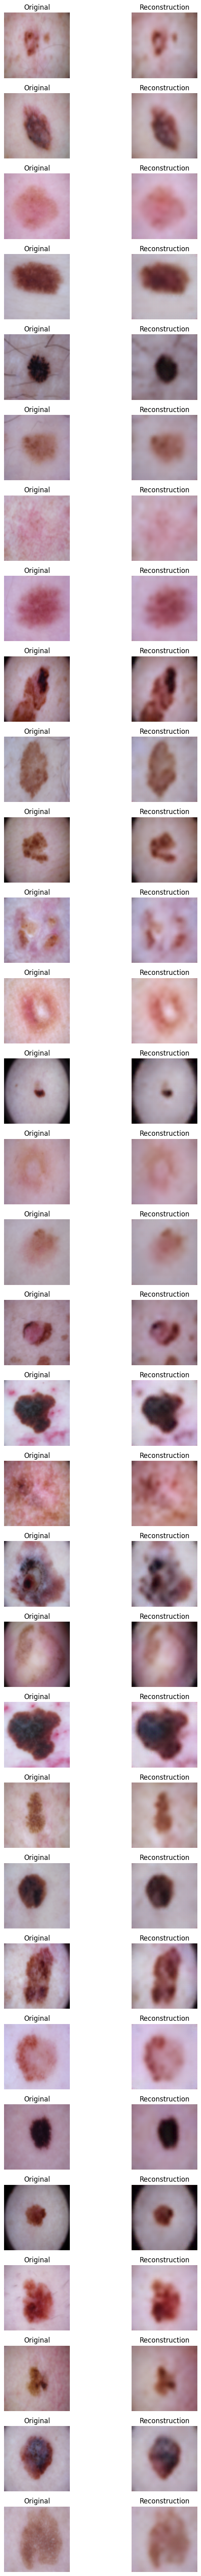

In [19]:
import matplotlib.pyplot as plt

images, _ = next(iter(test_data_loader))
images = images.to(device)

with torch.no_grad():
    z_e = model.encoder(images)
    z_e = model.pre_quantization_conv(z_e)
    embedding_loss, z_q, perplexity, _, min_encoding_indices = model.vector_quantization(z_e)
    reconstructions = model.decoder(z_q)

# Convert tensors to numpy arrays
images = images.cpu().numpy()
reconstructions = reconstructions.cpu().numpy()

# Plot original images and reconstructions
num_images = images.shape[0]
fig, axs = plt.subplots(num_images, 2, figsize=(8, 2*num_images))
for i in range(num_images):
    axs[i, 0].imshow(images[i].transpose(1, 2, 0))
    axs[i, 0].set_title('Original')
    axs[i, 0].axis('off')
    
    axs[i, 1].imshow(reconstructions[i].transpose(1, 2, 0))
    axs[i, 1].set_title('Reconstruction')
    axs[i, 1].axis('off')

plt.tight_layout()
plt.show()


## PixelCNN Test data Inference TASK2

In [21]:
import torch

# Define the file path of the saved model
model_path = "/home/user/Desktop/vamsi/class/Deep_Learning/Assignment_5/pixelcnn_8_models/pixelcnn_latent_model.pth"


pixelcnn = PixelCNN(
    in_channels=64,
    out_channels=64,
    n_residual=15,
    residual_channels=64,
    head_channels=32
).to(device)


# Load the model state_dict
model_state_dict = torch.load(model_path)

# Load the state_dict into the model
pixelcnn.load_state_dict(model_state_dict)

# If you want to use the model for inference, you can set it to evaluation mode
pixelcnn.eval()

PixelCNN(
  (_input): CausalConv2d(64, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (_causal_layers): ModuleList(
    (0-14): 15 x CausalResidualBlock(
      (_net): Sequential(
        (0): ReLU()
        (1): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1))
        (2): ReLU()
        (3): CausalConv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): ReLU()
        (5): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
      )
    )
  )
  (_head): Sequential(
    (0): ReLU()
    (1): Conv2d(128, 32, kernel_size=(1, 1), stride=(1, 1))
    (2): ReLU()
    (3): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1))
  )
)

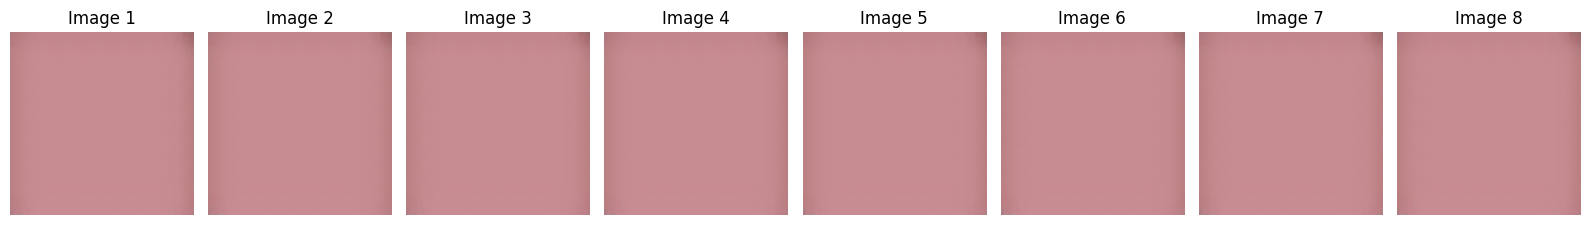

In [22]:
import matplotlib.pyplot as plt

with torch.no_grad():
    for latent_codes in DataLoader(test_latent_codes, batch_size=32):
        latent_codes = latent_codes.to(device)
        output = pixelcnn(latent_codes)
        reconstructions = model.decoder(output)

# Convert tensors to numpy arrays
reconstructions = reconstructions.cpu().numpy()

# Plot the 8 reconstructed images in one row
num_images = 8
fig, axs = plt.subplots(1, num_images, figsize=(16, 4))
for i in range(num_images):
    axs[i].imshow(reconstructions[i].transpose(1, 2, 0))
    axs[i].set_title(f"Image {i+1}")
    axs[i].axis('off')

plt.tight_layout()
plt.show()


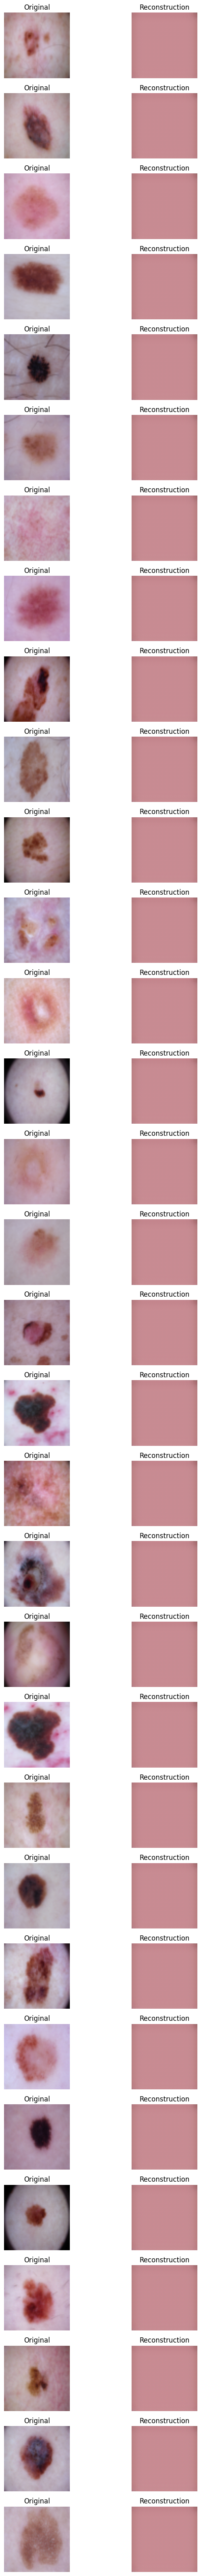

In [23]:
import matplotlib.pyplot as plt

images, _ = next(iter(test_data_loader))
images = images.to(device)

with torch.no_grad():
    z_e = model.encoder(images)
    z_e = model.pre_quantization_conv(z_e)
    embedding_loss, z_q, perplexity, _, min_encoding_indices = model.vector_quantization(z_e)
    z_q = pixelcnn(z_q)
    reconstructions = model.decoder(z_q)

# Convert tensors to numpy arrays
images = images.cpu().numpy()
reconstructions = reconstructions.cpu().numpy()

# Plot original images and reconstructions
num_images = images.shape[0]
fig, axs = plt.subplots(num_images, 2, figsize=(8, 2*num_images))
for i in range(num_images):
    axs[i, 0].imshow(images[i].transpose(1, 2, 0))
    axs[i, 0].set_title('Original')
    axs[i, 0].axis('off')
    
    axs[i, 1].imshow(reconstructions[i].transpose(1, 2, 0))
    axs[i, 1].set_title('Reconstruction')
    axs[i, 1].axis('off')

plt.tight_layout()
plt.show()


## Gated CNN TASK 2

In [17]:
class GatedConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
        super(GatedConv2d, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.gate = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        return self.conv(x) * self.sigmoid(self.gate(x))

class GatedCNN(nn.Module):
    def __init__(self, input_channels, hidden_dim):
        super(GatedCNN, self).__init__()
        self.gate1 = GatedConv2d(input_channels, hidden_dim, 3, padding=1)
        self.gate2 = GatedConv2d(hidden_dim, hidden_dim, 3, padding=1)
        self.final = nn.Conv2d(hidden_dim, 64, 1)  # Assuming output is an image with 3 channels

    def forward(self, x):
        x = F.relu(self.gate1(x))
        x = F.relu(self.gate2(x))
        return self.final(x)


In [32]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Dummy tensor representing batch of images with size 32x64x16x16
batch_images = torch.randn(32, 64, 16, 16)

# Resize images from 16x16 to 64x64
batch_images_resized = F.interpolate(batch_images, size=(64, 64), mode='nearest')

# Define a 1x1 convolutional layer to reduce channels from 64 to 3
conv1x1 = nn.Conv2d(64, 3, kernel_size=1)

# Apply the 1x1 convolutional layer to the resized images
batch_images_channels_reduced = conv1x1(batch_images_resized)

print(batch_images_channels_reduced.shape)  # Output: torch.Size([32, 3, 64, 64])


torch.Size([32, 3, 64, 64])


In [18]:
print(latent_representations.shape[1])

64


## Wanddb GatedCnn Log

In [19]:
gated_cnn = GatedCNN(input_channels=64, hidden_dim=64).to(device)

In [20]:
import wandb

optimizer = torch.optim.Adam(gated_cnn.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

# Define the folder to save the best model
save_dir = 'gatedcnn_8_models_wanddb'
os.makedirs(save_dir, exist_ok=True)

best_loss = float('inf')
best_model_path = None
# Initialize WandB
wandb.init(project="gated cnn revised", name="loss epoch")
for epoch in range(25):
    for latent_codes in DataLoader(latent_representations, batch_size=32):
        latent_codes = latent_codes.to(device)
        optimizer.zero_grad()

        output = gated_cnn(latent_codes)
        loss = loss_fn(output, latent_codes)
        loss.backward()
        optimizer.step()
    
    epoch_loss = loss.item()
    print(f"Epoch {epoch}: Loss {epoch_loss}")

    # Log the loss to WandB
    wandb.log({"Epoch": epoch, "Loss": epoch_loss})

    # Save the model if it improves the best loss
    if epoch_loss < best_loss:
        best_loss = epoch_loss
        if best_model_path is not None:
            os.remove(best_model_path)  # Remove the previously saved best model
        best_model_name = f"gated_cnn_best.pth"
        best_model_path = os.path.join(save_dir, best_model_name)
        torch.save(gated_cnn.state_dict(), best_model_path)

# Finish the training run
wandb.finish()
print("Model Saved")


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: vamsi8106 (vamsi_8106). Use `wandb login --relogin` to force relogin


Epoch 0: Loss 7.00443924870342e-05
Epoch 1: Loss 2.297596074640751e-05
Epoch 2: Loss 3.386978278285824e-05
Epoch 3: Loss 1.1000645827152766e-05
Epoch 4: Loss 1.0880651643674355e-05
Epoch 5: Loss 8.115091986837797e-06
Epoch 6: Loss 9.718472028907854e-06
Epoch 7: Loss 6.794572982471436e-06
Epoch 8: Loss 2.4421340640401468e-05
Epoch 9: Loss 7.28877421352081e-06
Epoch 10: Loss 4.6803688746877015e-06
Epoch 11: Loss 7.751112207188271e-06
Epoch 12: Loss 4.488134891289519e-06
Epoch 13: Loss 3.895189820468659e-06
Epoch 14: Loss 4.091274149686797e-06
Epoch 15: Loss 4.6456348172796424e-06
Epoch 16: Loss 3.7903309930698015e-06
Epoch 17: Loss 4.676101070799632e-06
Epoch 18: Loss 3.2799241580505623e-06
Epoch 19: Loss 2.9865082069591153e-06
Epoch 20: Loss 3.010723730767495e-06
Epoch 21: Loss 2.785355945889023e-06
Epoch 22: Loss 5.16897080160561e-06
Epoch 23: Loss 1.6815813069115393e-05
Epoch 24: Loss 2.4706787371542305e-06


Model Saved


In [27]:
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

# Initialize your model, optimizer, and loss function
gated_cnn = GatedCNN(input_channels=64, hidden_dim=64).to(device)
optimizer = torch.optim.Adam(gated_cnn.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

# Define the folder to save the best model
save_dir = 'gatedcnn_8_models'
os.makedirs(save_dir, exist_ok=True)

best_loss = float('inf')
best_model_path = None

for epoch in range(25):
    for latent_codes in DataLoader(latent_representations, batch_size=32):
        latent_codes = latent_codes.to(device)
        optimizer.zero_grad()

        output = gated_cnn(latent_codes)
        loss = loss_fn(output, latent_codes)
        loss.backward()
        optimizer.step()
    
    epoch_loss = loss.item()
    print(f"Epoch {epoch}: Loss {epoch_loss}")

    # Save the model if it improves the best loss
    if epoch_loss < best_loss:
        best_loss = epoch_loss
        if best_model_path is not None:
            os.remove(best_model_path)  # Remove the previously saved best model
        best_model_name = f"gated_cnn_best.pth"
        best_model_path = os.path.join(save_dir, best_model_name)
        torch.save(gated_cnn.state_dict(), best_model_path)
print("Model Saved")


Epoch 0: Loss 5.021740435040556e-05
Epoch 1: Loss 1.7155556633952074e-05
Epoch 2: Loss 8.047838491620496e-06
Epoch 3: Loss 1.5295736375264823e-05
Epoch 4: Loss 5.03781984662055e-06
Epoch 5: Loss 4.235594587953528e-06
Epoch 6: Loss 3.751363010451314e-06
Epoch 7: Loss 3.4449792565283133e-06
Epoch 8: Loss 3.485142087811255e-06
Epoch 9: Loss 3.0508838335663313e-06
Epoch 10: Loss 2.726077809711569e-06
Epoch 11: Loss 3.335836254336755e-06
Epoch 12: Loss 6.055599897081265e-06
Epoch 13: Loss 2.6919633455690928e-06
Epoch 14: Loss 1.4099300642556045e-05
Epoch 15: Loss 3.339467866680934e-06
Epoch 16: Loss 1.8758529449769412e-06
Epoch 17: Loss 1.6564847555855522e-06
Epoch 18: Loss 2.580427690190845e-06
Epoch 19: Loss 1.4494446986645926e-05
Epoch 20: Loss 1.541169808660925e-06
Epoch 21: Loss 1.5160928796831286e-06
Epoch 22: Loss 7.717239896010142e-06
Epoch 23: Loss 8.63824607222341e-06
Epoch 24: Loss 1.3237554412626196e-06
Model Saved


In [28]:
gated_cnn = GatedCNN(input_channels=64, hidden_dim=64).to(device)
model_path = "/home/user/Desktop/vamsi/class/Deep_Learning/Assignment_5/gated_cnn_8/gated_cnn_best.pth"

# Load the model state_dict
model_state_dict = torch.load(model_path)

# Load the state_dict into the model
gated_cnn.load_state_dict(model_state_dict)

# If you want to use the model for inference, you can set it to evaluation mode
gated_cnn.eval()

GatedCNN(
  (gate1): GatedConv2d(
    (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (gate): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (sigmoid): Sigmoid()
  )
  (gate2): GatedConv2d(
    (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (gate): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (sigmoid): Sigmoid()
  )
  (final): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


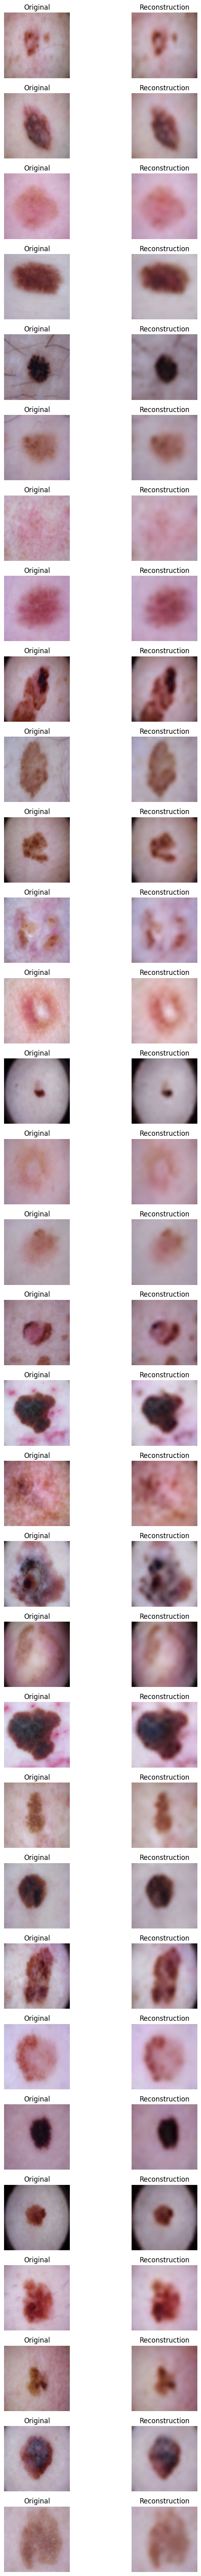

In [29]:
import matplotlib.pyplot as plt

images, _ = next(iter(test_data_loader))
images = images.to(device)

with torch.no_grad():
    z_e = model.encoder(images)
    z_e = model.pre_quantization_conv(z_e)
    embedding_loss, z_q, perplexity, _, min_encoding_indices = model.vector_quantization(z_e)
    z_q = gated_cnn(z_q)
    reconstructions = model.decoder(z_q)

# Convert tensors to numpy arrays
images = images.cpu().numpy()
reconstructions = reconstructions.cpu().numpy()

# Plot original images and reconstructions
num_images = images.shape[0]
fig, axs = plt.subplots(num_images, 2, figsize=(8, 2*num_images))
for i in range(num_images):
    axs[i, 0].imshow(images[i].transpose(1, 2, 0))
    axs[i, 0].set_title('Original')
    axs[i, 0].axis('off')
    
    axs[i, 1].imshow(reconstructions[i].transpose(1, 2, 0))
    axs[i, 1].set_title('Reconstruction')
    axs[i, 1].axis('off')

plt.tight_layout()
plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


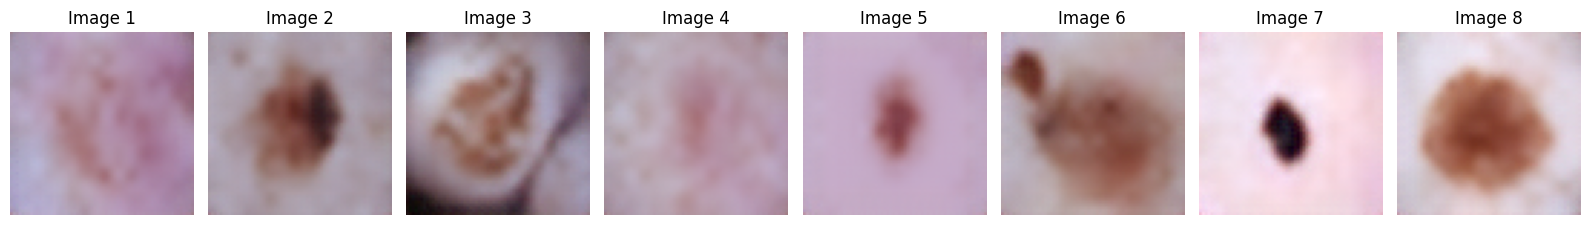

In [30]:
import matplotlib.pyplot as plt

with torch.no_grad():
    for latent_codes in DataLoader(test_latent_codes, batch_size=32):
        latent_codes = latent_codes.to(device)
        output = gated_cnn(latent_codes)
        reconstructions = model.decoder(output)

# Convert tensors to numpy arrays
reconstructions = reconstructions.cpu().numpy()

# Plot the 8 reconstructed images in one row
num_images = 8
fig, axs = plt.subplots(1, num_images, figsize=(16, 4))
for i in range(num_images):
    axs[i].imshow(reconstructions[i].transpose(1, 2, 0))
    axs[i].set_title(f"Image {i+1}")
    axs[i].axis('off')

plt.tight_layout()
plt.show()


## MADE Model

In [13]:
class MaskedLinear(nn.Linear):
    """A Linear layer with masks that turn off some of the layer's weights."""

    def __init__(self, in_features, out_features, bias=True):
        super().__init__(in_features, out_features, bias)
        self.register_buffer("mask", torch.ones((out_features, in_features)))

    def set_mask(self, mask):
        self.mask.data.copy_(mask)

    def forward(self, x):
        self.weight.data *= self.mask
        return super().forward(x)

In [14]:
def auto_reshape(fn):

    def wrapped_fn(self, x, *args, **kwargs):
        original_shape = x.shape
        x = x.view(original_shape[0], -1)
        y = fn(self, x, *args, **kwargs)
        return y.view(original_shape)

    return wrapped_fn

In [15]:
class MADE(nn.Module):
    def __init__(self, input_dim, hidden_dims=None, n_masks=1, sample_fn=None):
        super().__init__()
        self._input_dim = input_dim
        self._dims = [self._input_dim] + (hidden_dims or []) + [self._input_dim]
        self._n_masks = n_masks
        self._mask_seed = 0

        layers = []
        for i in range(len(self._dims) - 1):
            in_dim, out_dim = self._dims[i], self._dims[i + 1]
            layers.append(MaskedLinear(in_dim, out_dim))
            layers.append(nn.ReLU())
        self._net = nn.Sequential(*layers[:-1])

    def _sample_masks(self):
        rng = np.random.RandomState(seed=self._mask_seed % self._n_masks)
        self._mask_seed += 1

        # Sample connectivity patterns.
        conn = [rng.permutation(self._input_dim)]
        for i, dim in enumerate(self._dims[1:-1]):
            low = 0 if i == 0 else np.min(conn[i - 1])
            high = self._input_dim - 1
            conn.append(rng.randint(low, high, size=dim))
        conn.append(np.copy(conn[0]))

        # Create masks.
        masks = [
            conn[i - 1][None, :] <= conn[i][:, None] for i in range(1, len(conn) - 1)
        ]
        masks.append(conn[-2][None, :] < conn[-1][:, None])

        return [torch.from_numpy(mask.astype(np.uint8)) for mask in masks], conn[-1]

    def _forward(self, x, masks):
        layers = [
            layer for layer in self._net.modules() if isinstance(layer, MaskedLinear)
        ]
        for layer, mask in zip(layers, masks):
            layer.set_mask(mask)
        return self._net(x)

    @auto_reshape
    def forward(self, x):

        masks, _ = self._sample_masks()
        return self._forward(x, masks)

    @torch.no_grad()
    def sample(self, n_samples, conditioned_on=None):
        """See the base class."""
        conditioned_on = self._get_conditioned_on(n_samples, conditioned_on)
        return self._sample(conditioned_on)

    @auto_reshape
    def _sample(self, x):
        masks, ordering = self._sample_masks()
        ordering = np.argsort(ordering)
        for dim in ordering:
            out = self._forward(x, masks)[:, dim]
            out = self._sample_fn(out)
            x[:, dim] = torch.where(x[:, dim] < 0, out, x[:, dim])
        return x

In [16]:
# Test tensor setup for the MADE architecture
batch_size = 32
channels1 = 64
height1, width1 = 16,16
input_dim1= channels1 * height1 * width1  # Flattened input dimension
input_tensor1 = torch.randn(batch_size, channels1, height1, width1)  # Create sample tensor

# Initialize the MADE architecture with a flattened input dimension
made = MADE(input_dim=input_dim1, hidden_dims=[8000, 8000])

# Test the forward pass through MADE
output_tensor = made(input_tensor1)

print("Input shape:", input_tensor1.shape)
# Check the output shape
print("Output shape:", output_tensor.shape)  # Expected: [32, 3, 64, 64]

Input shape: torch.Size([32, 64, 16, 16])
Output shape: torch.Size([32, 64, 16, 16])


In [17]:
# Define model parameters
h_dim = 64
res_h_dim = 32
n_res_layers = 2
n_embeddings = 512
embedding_dim = 64 # input channels of 
in_channels = 64
out_channels = 64
beta = 0.25

model = VQVAE(h_dim, res_h_dim, n_res_layers,
              n_embeddings, embedding_dim, beta,in_channels,out_channels).to(device)
# Load the state dictionary
state_dict = torch.load('/home/user/Desktop/vamsi/class/Deep_Learning/Assignment_5/save_directory_8_zq/best_model.pth')

# Load the state dictionary into the model
model.load_state_dict(state_dict)
model = model.to(device)

In [18]:
import numpy as np

# Define the file path
file_path = "/home/user/Desktop/vamsi/class/Deep_Learning/Assignment_5/save_directory_8_zq/latent_representations.npy"

# Load the numpy array
loaded_train_array = np.load(file_path)

# Now you have your array loaded, and you can use it as needed
print("Loaded array shape:", loaded_train_array.shape)


Loaded array shape: (9015, 64, 16, 16)


In [ ]:
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

optimizer = torch.optim.Adam(made.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

# Define the folder to save the best model
save_dir = 'made_8_models'
os.makedirs(save_dir, exist_ok=True)

best_loss = float('inf')
best_model_path = None
made = made.to(device)
for epoch in range(10):
    for latent_codes in DataLoader(loaded_train_array, batch_size=32):
        latent_codes = latent_codes.to(device)
        optimizer.zero_grad()

        output = made(latent_codes)
        loss = loss_fn(output, latent_codes)
        loss.backward()
        optimizer.step()
    
    epoch_loss = loss.item()
    print(f"Epoch {epoch}: Loss {epoch_loss}")

    # Save the model if it improves the best loss
    if epoch_loss < best_loss:
        best_loss = epoch_loss
        if best_model_path is not None:
            os.remove(best_model_path)  # Remove the previously saved best model
        best_model_name = f"made_best.pth"
        best_model_path = os.path.join(save_dir, best_model_name)
        torch.save(made.state_dict(), best_model_path)
print("Model Saved")


In [ ]:
# Test tensor setup for the MADE architecture
batch_size = 32
channels1 = 64
height1, width1 = 16,16
input_dim1= channels1 * height1 * width1  # Flattened input dimension
input_tensor1 = torch.randn(batch_size, channels1, height1, width1)  # Create sample tensor

# Initialize the MADE architecture with a flattened input dimension
made = MADE(input_dim=input_dim1, hidden_dims=[8000, 8000])

# Test the forward pass through MADE
output_tensor = made(input_tensor1)

print("Input shape:", input_tensor1.shape)
# Check the output shape
print("Output shape:", output_tensor.shape)  # Expected: [32, 3, 64, 64]

In [ ]:
model_path = "/home/user/Desktop/vamsi/class/Deep_Learning/Assignment_5/made_8_models/made_best.pth"

# Load the model state_dict
model_state_dict = torch.load(model_path)

# Load the state_dict into the model
made.load_state_dict(model_state_dict)

# If you want to use the model for inference, you can set it to evaluation mode
made.eval()

In [ ]:
import numpy as np

# Define the file path
file_path = "/home/user/Desktop/vamsi/class/Deep_Learning/Assignment_5/save_directory_8_zq/latent_test_representations.npy"

# Load the numpy array
loaded_test_array = np.load(file_path)

# Now you have your array loaded, and you can use it as needed
print("Loaded array shape:", loaded_test_array.shape)


In [ ]:
import matplotlib.pyplot as plt

with torch.no_grad():
    for latent_codes in DataLoader(test_latent_codes, batch_size=32):
        latent_codes = latent_codes.to(device)
        output = made(latent_codes)
        reconstructions = model.decoder(output)

# Convert tensors to numpy arrays
reconstructions = reconstructions.cpu().numpy()

# Plot the 8 reconstructed images in one row
num_images = 5
fig, axs = plt.subplots(1, num_images, figsize=(16, 4))
for i in range(num_images):
    axs[i].imshow(reconstructions[i].transpose(1, 2, 0))
    axs[i].set_title(f"Image {i+1}")
    axs[i].axis('off')

plt.tight_layout()
plt.show()
